# ECoG preprocessing tutorial

Bouchard Lab - John Hermiz

Dec 15, 2020

# Overview of steps
- Resampling
- Re-referencing
- Notch filtering
- Time-frequency power calculation
- Normalizing power for each frequency

## Some preliminaries

**Repo**: 
https://github.com/BouchardLab/process_nwb

**Docs**:
https://process-nwb.readthedocs.io/en/latest/

- `process_nwb` is a python package for preprocessing ECoG data.
- The latest verison of this package can be found on github and documention can be found at readthedocs
- This package is designed to take in nwb. For simplicity, I will just illustrate how the "core" functionality works without using NWB

### Package imports

In [131]:
import process_nwb as ecog
import numpy as np
import matplotlib.pyplot as plt

### Create synthetic neural data and store into NWB

- Synthetic neural data is created by by convolving white noise with a boxcar
- Common line noise (60Hz) is added but with different weights to each channel

Text(0.5, 1.0, 'One channel of neural data')

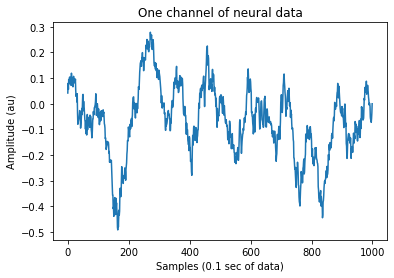

In [132]:
num_channels = 4
duration = 10 #seconds
sample_rate = 10000 #hz
kernel_length = 50
snr = 2.
np.random.seed(0)
line_noise_freq = 60. #hz

#Create synthetic neural data by convolving white noise with a boxcar
signal_data = np.random.randn(duration*sample_rate, num_channels)
kernel = np.ones(kernel_length)/kernel_length

for ch in range(num_channels):
    signal_data[:,ch] = np.convolve(signal_data[:,ch], kernel, mode='same')
    
#Add common noise but with different weights to each channel
t = np.linspace(0, duration, duration*sample_rate)
line_noise = np.sin(2*np.pi*t*line_noise_freq).reshape(-1, 1)
line_noise = np.repeat(line_noise, 4, axis=1)
neural_data = snr*signal_data + line_noise@np.diag(np.random.randn(4))

#Here is one channel of the pure neural data (signal only)
plt.plot(signal_data[:1000,0])
plt.xlabel('Samples (0.1 sec of data)')
plt.ylabel('Amplitude (au)')
plt.title('One channel of neural data')

Text(0.5, 1.0, 'One channel of neural data')

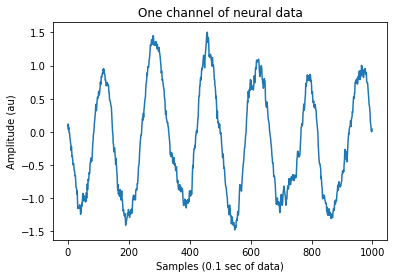

In [133]:
#Here's signal + noise
plt.plot(neural_data[:1000,0])
plt.xlabel('Samples (0.1 sec of data)')
plt.ylabel('Amplitude (au)')
plt.title('One channel of neural data')

## Resampling in the frequency domain

- Resample the data down to make computations much faster downstream
- The resampling algorithm is done in the frequency domain

In [134]:
from process_nwb import resample

Text(0.5, 1.0, 'One channel of neural data')

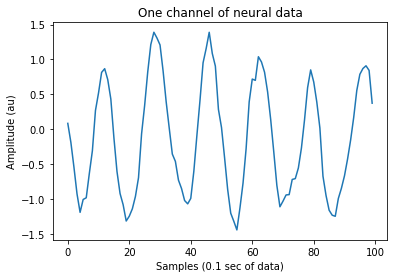

In [135]:

new_sample_rate = 1000 #hz
rs_data = resample.resample(neural_data, new_sample_rate, sample_rate, real=True, axis=0)

plt.plot(rs_data[:100,0])
plt.xlabel('Samples (0.1 sec of data)')
plt.ylabel('Amplitude (au)')
plt.title('One channel of neural data')

## Re-referencing with common average referencing

- Often times there is common noise from neural recording such as movement artifact or line noise
- To remove, a robust estimate of the average across all signals (for each timepoint) is calculated than subtracted all channels

Text(0.5, 1.0, 'One channel of neural data')

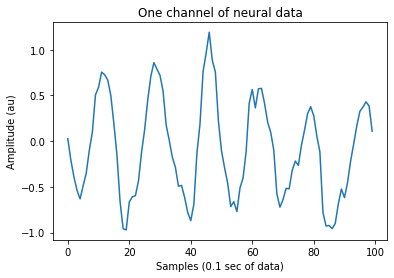

In [136]:
car_data = ecog.common_referencing.subtract_CAR(rs_data, mean_frac=.95, round_func=np.ceil)

plt.plot(car_data[:100,0])
plt.xlabel('Samples (0.1 sec of data)')
plt.ylabel('Amplitude (au)')
plt.title('One channel of neural data')

## Notch filtering

- Since line noise is not of equal strength across channels, CAR fails at getting rid of all line noise. 
- Therefore, notch filtering is used to remove line noise on all channels

Text(0.5, 1.0, 'One channel of neural data')

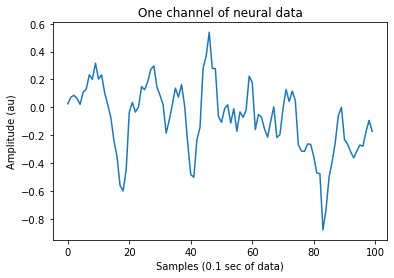

In [137]:
nth_data = ecog.linenoise_notch.apply_linenoise_notch(car_data, new_sample_rate, fft=True, noise_hz=line_noise_freq)

plt.plot(nth_data[:100,0])
plt.xlabel('Samples (0.1 sec of data)')
plt.ylabel('Amplitude (au)')
plt.title('One channel of neural data')

In [138]:
from scipy.signal import welch
from scipy.signal.windows import kaiser

Text(0.5, 1.0, 'Post notch filtering')

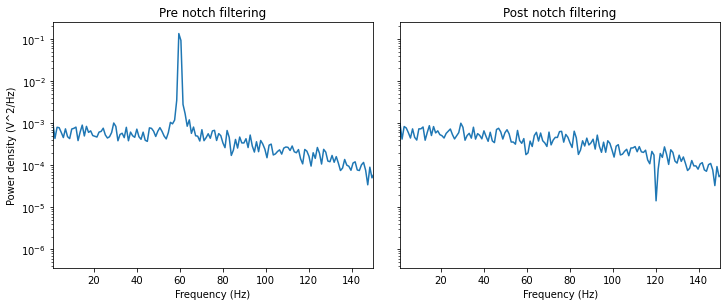

In [139]:
window = kaiser(1024, 2)
freq, car_pwr = welch(car_data[:,0], fs=new_sample_rate, window=window)
_, nth_pwr = welch(nth_data[:,0], fs=new_sample_rate, window=window)

fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True, sharex=True)
fig.tight_layout()
axs[0].semilogy(freq, car_pwr)
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Power density (V^2/Hz)')
axs[0].set_xlim([1, 150])
axs[0].set_title('Pre notch filtering')

axs[1].semilogy(freq, nth_pwr)
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_xlim([1, 150])
axs[1].set_title('Post notch filtering')

## Time-frequency decomposition with wavelets

- Here we decompose the neural time series into 6 different frequency bands using a wavelet transform
- The wavelet transform outputs the analytical amplitude, which is complex valued.
- I'm plotting the magnitude of analytical amplitude which is a proxy of band power

In [140]:
from process_nwb import wavelet_transform

In [141]:
tf_data, _, ctr_freq, bw = wavelet_transform.wavelet_transform(nth_data, new_sample_rate, filters='rat', hg_only=True, X_fft_h=None, npad=None)

In [142]:
tf_data.shape

(10000, 4, 6)

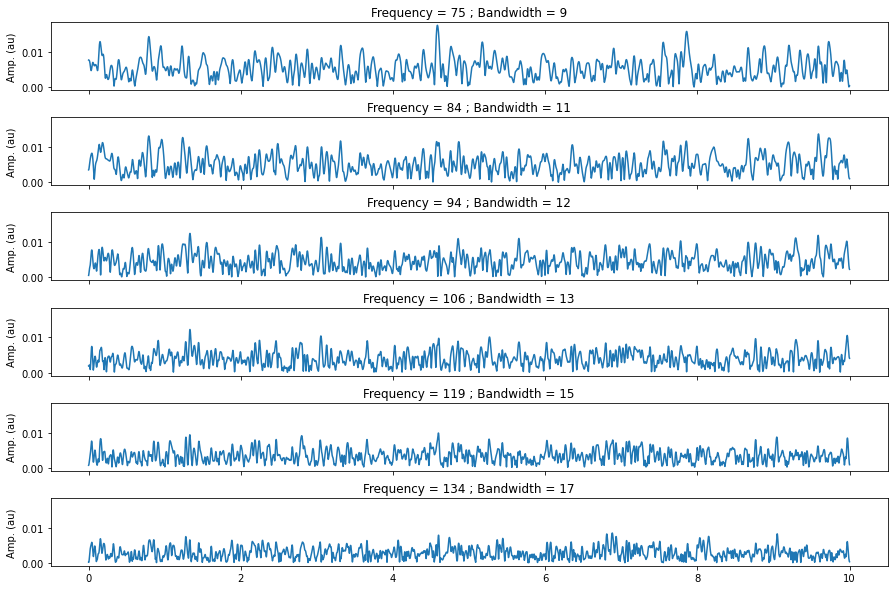

In [143]:
num_tf_signals = len(ctr_freq)
fig, axs = plt.subplots(num_tf_signals, 1, sharex=True, sharey=True, figsize=(15,10))
fig.subplots_adjust(hspace=0.4)
fig.tight_layout

time = np.linspace(0, duration, tf_data.shape[0])
for idx in range(num_tf_signals):
    sig = np.abs(tf_data[:,0,idx])
    axs[idx].plot(time, sig)
    axs[idx].set_title('Frequency = {0:.0f} ; Bandwidth = {1:0.0f}'.format(ctr_freq[idx], bw[idx]))
    axs[idx].set_ylabel('Amp. (au)')

## Normalizing power by z-scoring

- For neural data, power falls off with frequency so it can be difficult to compare amplitude changes across different frequency bands.
- To address this issue we normalize each frequency band by zscoring. 
- In this case, the mean and standard deviation are calculated over the entire signal, but if there's a baseline period(s) then it would make more sense to calculate mean and standard deviation over those period(s)

In [144]:
def zscore_signal(signal, mean=None, std=None):
    if mean is None:
        mean = np.mean(signal)
    if std is None:
        std = np.std(signal)
    return (signal - mean)/std

In [145]:
tf_norm_data = np.empty(tf_data.shape, dtype='complex')

for idx in range(num_tf_signals):
    for ch in range(num_channels):
        tf_norm_data[:,ch,idx] = zscore_signal(tf_data[:,ch,idx])

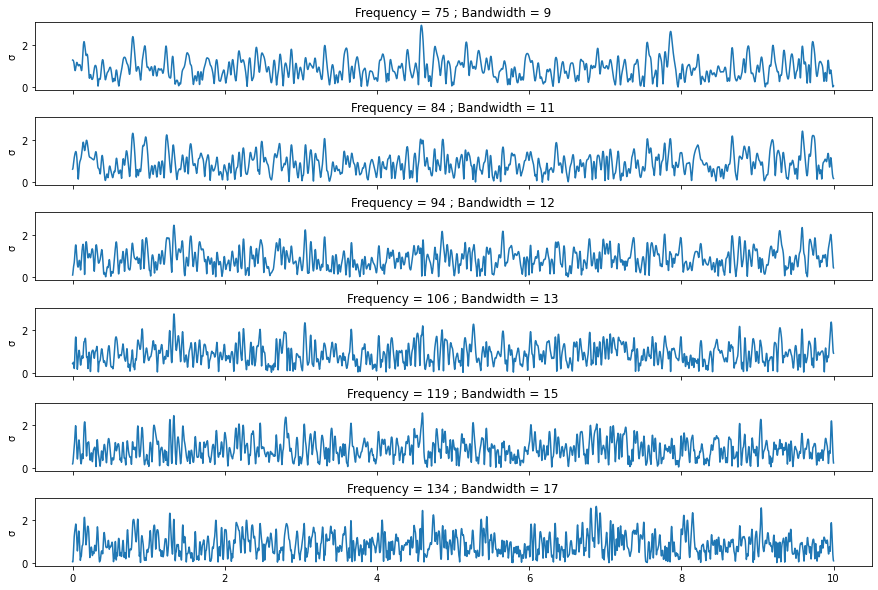

In [146]:
num_tf_signals = len(ctr_freq)
fig, axs = plt.subplots(num_tf_signals, 1, sharex=True, sharey=True,figsize=(15,10))
fig.subplots_adjust(hspace=0.4)
fig.tight_layout

time = np.linspace(0, duration, tf_data.shape[0])
for idx in range(num_tf_signals):
    sig = np.abs(tf_norm_data[:,0,idx])
    axs[idx].plot(time, sig)
    axs[idx].set_title('Frequency = {0:.0f} ; Bandwidth = {1:0.0f}'.format(ctr_freq[idx], bw[idx]))
    axs[idx].set_ylabel('σ')

## Congrats you now know how to preprocess ECoG signals!